In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns 


Bad key "text.kerning_factor" on line 4 in
/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
Train = pd.read_csv('Resources/train_df.csv')
Test = pd.read_csv('Resources/test_df.csv')

In [3]:
Train = Train[['Price','Suburb',
 'Address',
 'Rooms',
 'Type',
 'Method',
 'SellerG',
 'Date',
 'Distance',
 'Postcode',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'CouncilArea',
 'Lattitude',
 'Longtitude',
 'Regionname',
 'Propertycount']]

In [4]:
Test = Test[['Suburb',
 'Address',
 'Rooms',
 'Type',
 'Method',
 'SellerG',
 'Date',
 'Distance',
 'Postcode',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'CouncilArea',
 'Lattitude',
 'Longtitude',
 'Regionname',
 'Propertycount']]

In [5]:
print("Test", Test.shape, "Train", Train.shape)

Test (1239, 20) Train (4957, 21)


In [6]:
Train.YearBuilt = Train.YearBuilt.astype(str)
Test.YearBuilt = Test.YearBuilt.astype(str)

/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


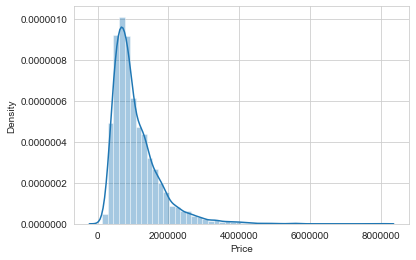

/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


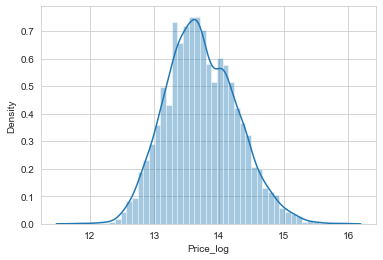

In [7]:
x = Train.Price
sns.set_style("whitegrid")
sns.distplot(x)
plt.show()

Train["Price_log"] = np.log(Train.Price)
x = Train.Price_log
sns.distplot(x)
plt.show()

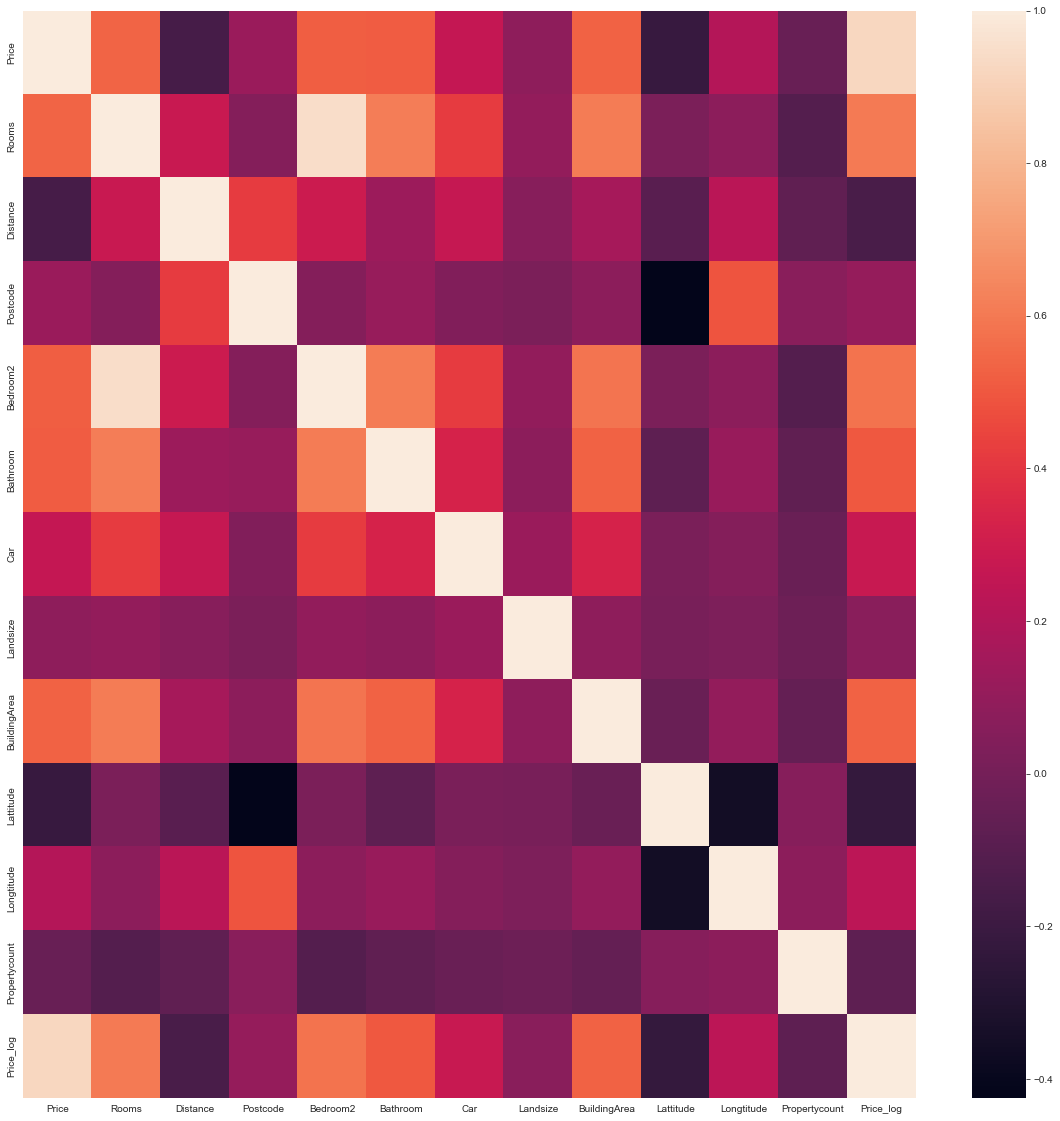

In [8]:
plt.figure(figsize=(20, 20))
sns.heatmap(Train.corr())
plt.savefig('Pictures/heatmap.png')

<Figure size 720x720 with 0 Axes>

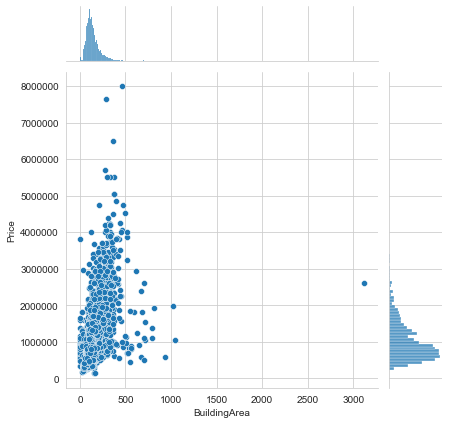

<Figure size 720x720 with 0 Axes>

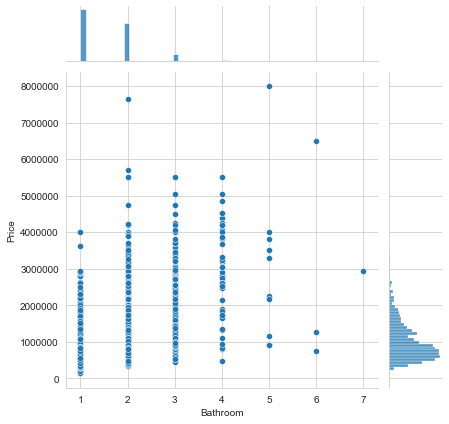

<Figure size 720x720 with 0 Axes>

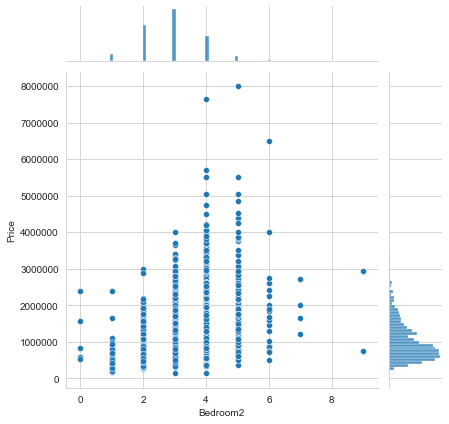

<Figure size 720x720 with 0 Axes>

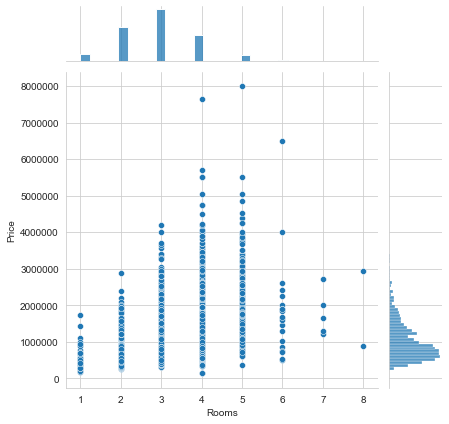

In [9]:
y = Train.Price
features = [
    "BuildingArea",
    "Bathroom",
    "Bedroom2",
    "Rooms",

]

for features in features:
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 10))
    x = Train[features]
    sns.jointplot(x=x, y=y, data=Train)

ValueError: Image size of 1059264x216 pixels is too large. It must be less than 2^16 in each direction.

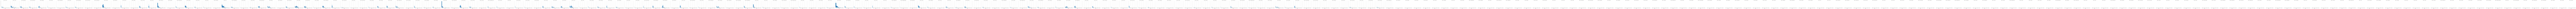

ValueError: Image size of 1059264x216 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1.05926e+06x216 with 4904 Axes>

In [10]:
features = Train.select_dtypes(include=['object']).columns

for features in features:
    g = sns.FacetGrid(Train, col=features)
    g.map(plt.hist, 'Price');


In [11]:
# Convert training and test data to one hot encoded numeric data
import sklearn
# Create a onehotencoder object that relables columns after transforming
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder


# Wrapper for one hot encoder to allow labelling of encoded variables
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(
            sparse_matrix.toarray(), columns=new_columns, index=X.index
        )
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f"{column}_<{self.categories_[i][j]}>")
                j += 1
        return new_columns


# Define funtion to encode categorrical variables with and rejoin to initial data


def transform(Train, df):

    # isolate categorical features
    cat_columns = df.select_dtypes(include=["object"]).columns
    cat_df = df[cat_columns]

    # isolate the numeric features
    numeric_df = df.select_dtypes(include=np.number)

    # initialise one hot encoder object spcify handle unknown and auto options to keep test and train same size
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    # Fit the endcoder to training data
    ohe.fit(Train[cat_columns])

    # transform input data
    df_processed = ohe.transform(cat_df)

    # concatinate numeric features from orginal tables with encoded features
    df_processed_full = pd.concat([df_processed, numeric_df], axis=1)

    return df_processed_full


# Transform training data to numeric form
Train_encoded = transform(Train, Train)
# Transform test data to numeric form
Test_encoded = transform(Train, Test)

# Check data sets are same width minus the two labels in Train
print("Test", Test_encoded.shape, "Train", Train_encoded.shape)

Test (1239, 5606) Train (4957, 5608)


In [20]:
# Model 0: Decision Tree
import time

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

x_train = Train_encoded.drop(columns=["Price", "Price_log"])
Y_train = Train_encoded.Price_log


# Initialise Gridsearch CV with 5 fold corssvalidation and root mse for socirn


def model_pipeline(model, param_grid, scoring):
    Tuned_Model = GridSearchCV(
        estimator=model, param_grid=param_grid, scoring=scoring, cv=5
    )

    # Fit model & Time the process for training the model
    print("running model")
    start_time = time.process_time()

    Tuned_Model.fit(x_train, Y_train)

    # End of fit time
    print(time.process_time() - start_time, "Seconds")
    print("finished running model")
    return Tuned_Model


# Generate results of best run


def plot_mean_scores(Tuned_Model, col, x, y, name):

    Results = pd.DataFrame(Tuned_Model.cv_results_)
    Results_Best = Results.loc[Results.rank_test_score == 1]

    # Initialize a grid of plots
    sns.set(font_scale=1.5)
    sns.set_style("darkgrid")
    col = col
    for col in col:
        grid = sns.FacetGrid(
            Results,
            col=col,
            hue="rank_test_score",
            palette="tab20c",
            legend_out=False,
            col_wrap=5,
            height=15,
        )

        # Draw a horizontal line to show the starting point
        grid.map(plt.axhline, y=0, ls=":", c=".5")

        # Draw marker on plot and decide what parameters to plot
        grid.map(sns.scatterplot, x, y, marker="o", s=200)

        # Adjust the arrangement of the plots
        grid.fig.tight_layout(w_pad=1)

        # Add legend to gird
        grid.add_legend()

    grid.savefig(name)

running model


/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'

/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/mark/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'

8.713199999999972 Seconds
finished running model


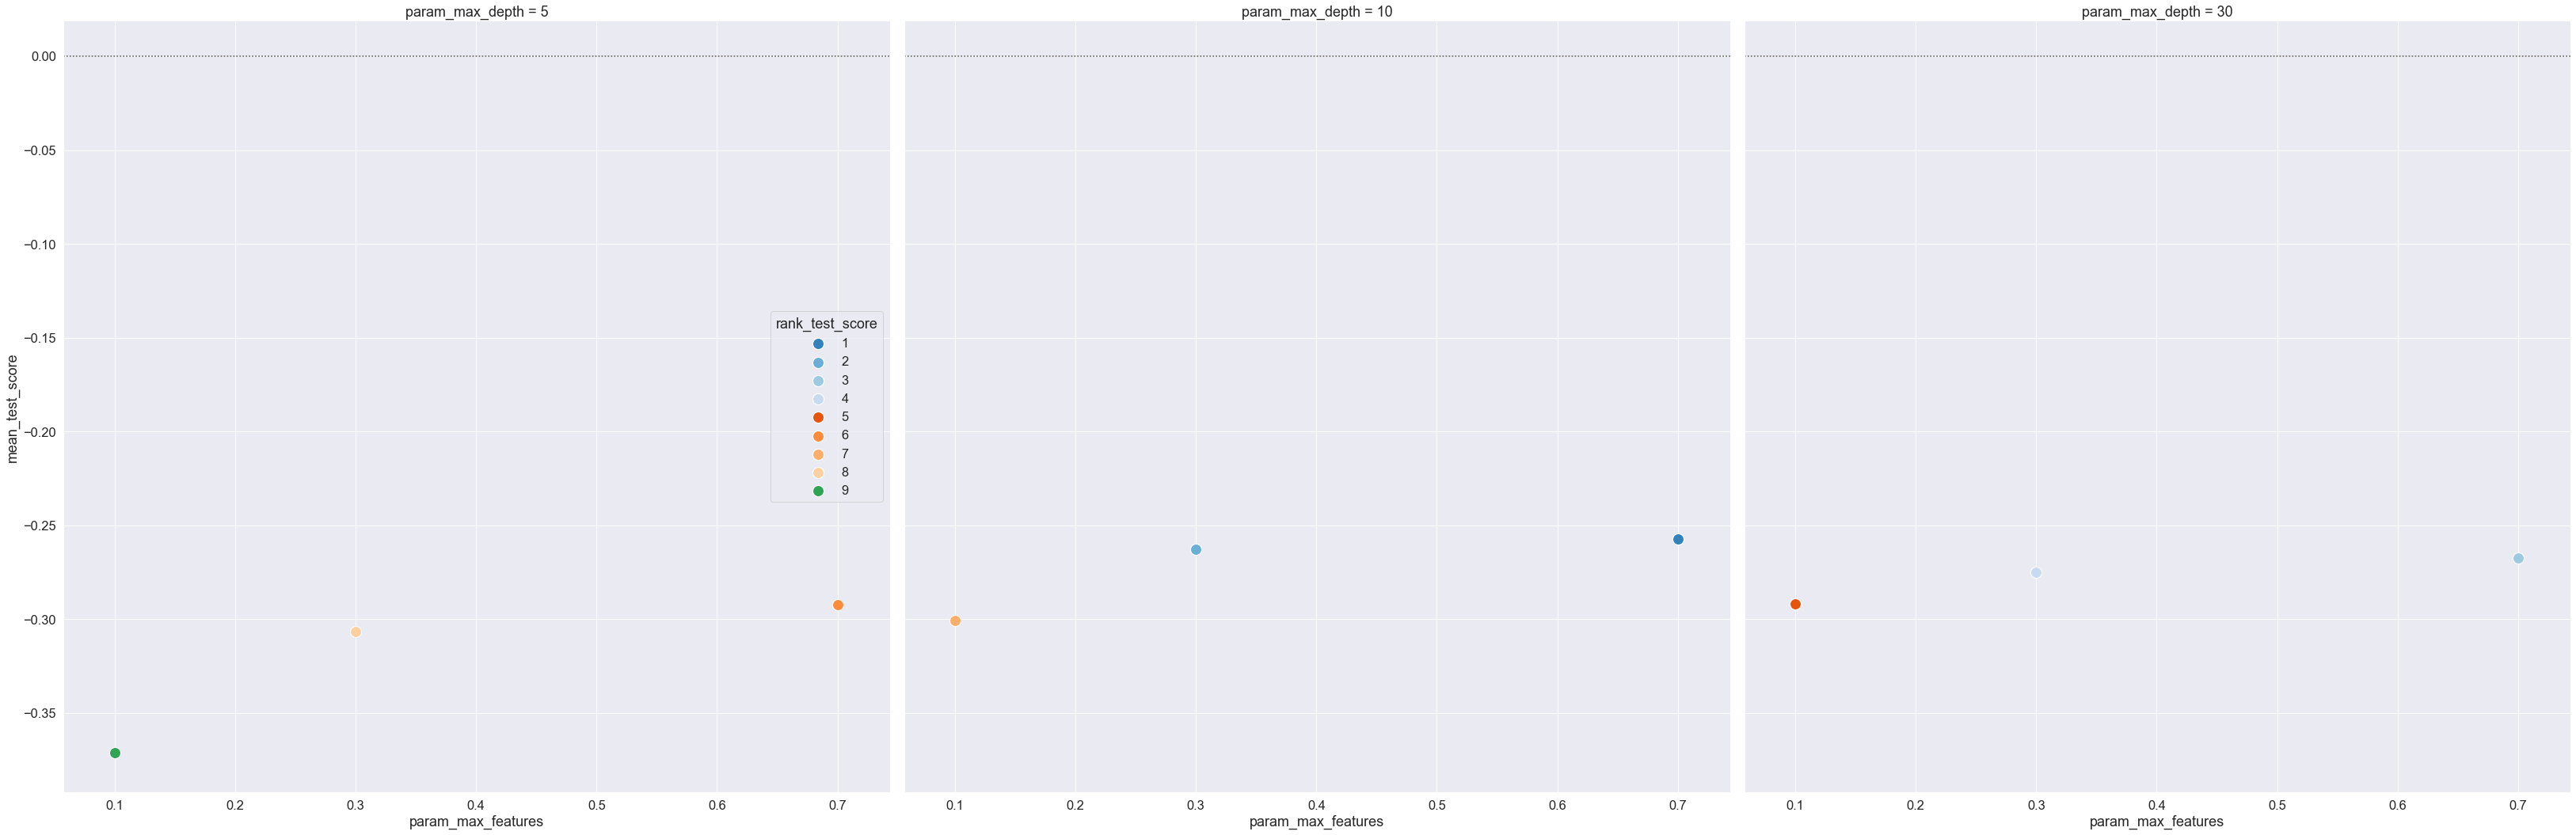

In [14]:
# Modelling

# Build a decision tree
# Set paramters for Grid Search CV
param_grid = {
    "max_depth": [5, 10, 30],
    "max_features": [0.1, 0.3, 0.7],
}
model = DecisionTreeRegressor(criterion="mse", random_state=0)

Tuned_Model = model_pipeline(model, param_grid, "neg_root_mean_squared_error")
plot_mean_scores(
    Tuned_Model,
    ["param_max_depth"],
    "param_max_features",
    "mean_test_score",
    "DecisionTree",
)
plt.savefig('pictures/decision_tree_graph.png')

running model
221.34191999999996 Seconds
finished running model


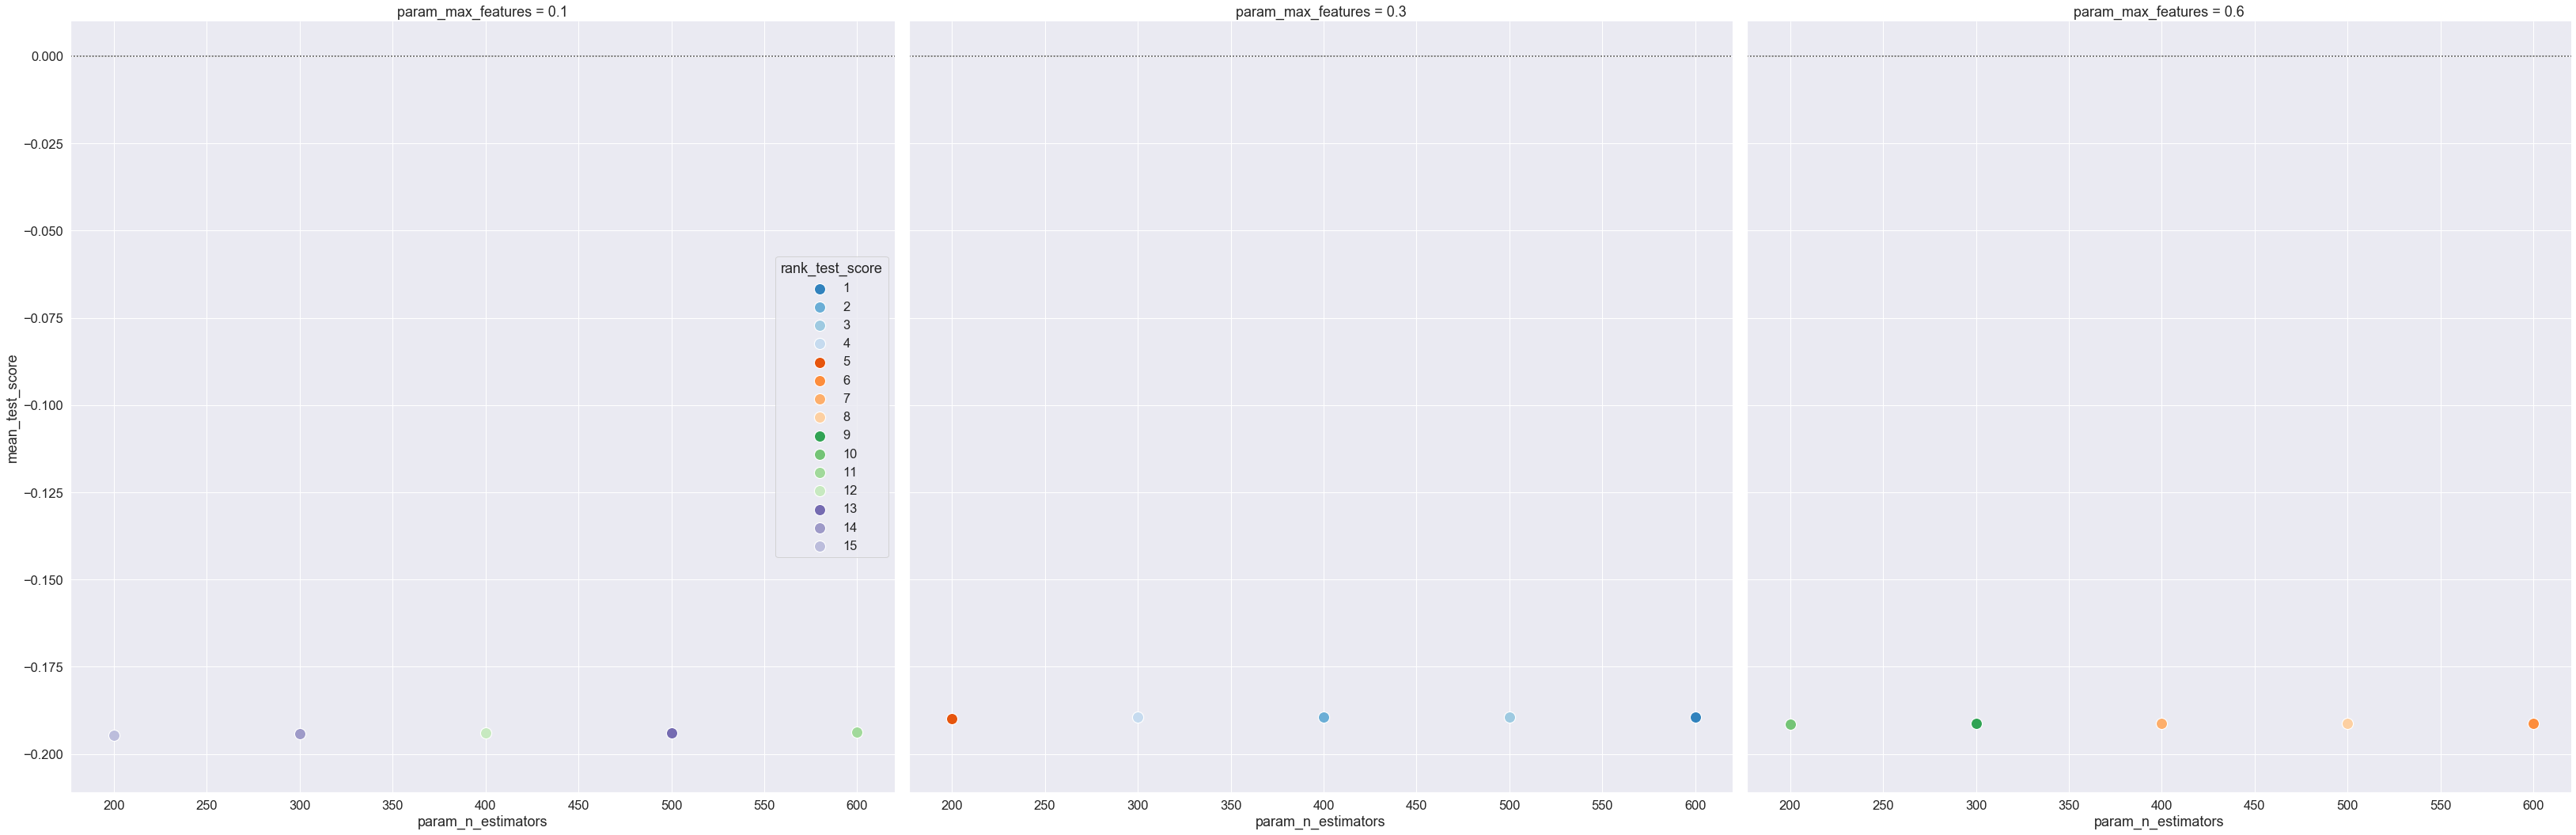

In [15]:
# Build a random forest
from sklearn.ensemble import RandomForestRegressor

# Set paramters for Grid Search
param_grid = {
    "n_estimators": [200, 300, 400, 500, 600],
    "max_features": [0.1, 0.3, 0.6],
}
# Initialise the random forest model
model2 = RandomForestRegressor(n_jobs=-1, random_state=0, bootstrap=True)

Tuned_Model2 = model_pipeline(model2, param_grid, "neg_root_mean_squared_error")
plot_mean_scores(
    Tuned_Model2,
    ["param_max_features"],
    "param_n_estimators",
    "mean_test_score",
    "RandomForest",
)
plt.savefig('pictures/random_forest_graph.png')

running model
874.741585 Seconds
finished running model


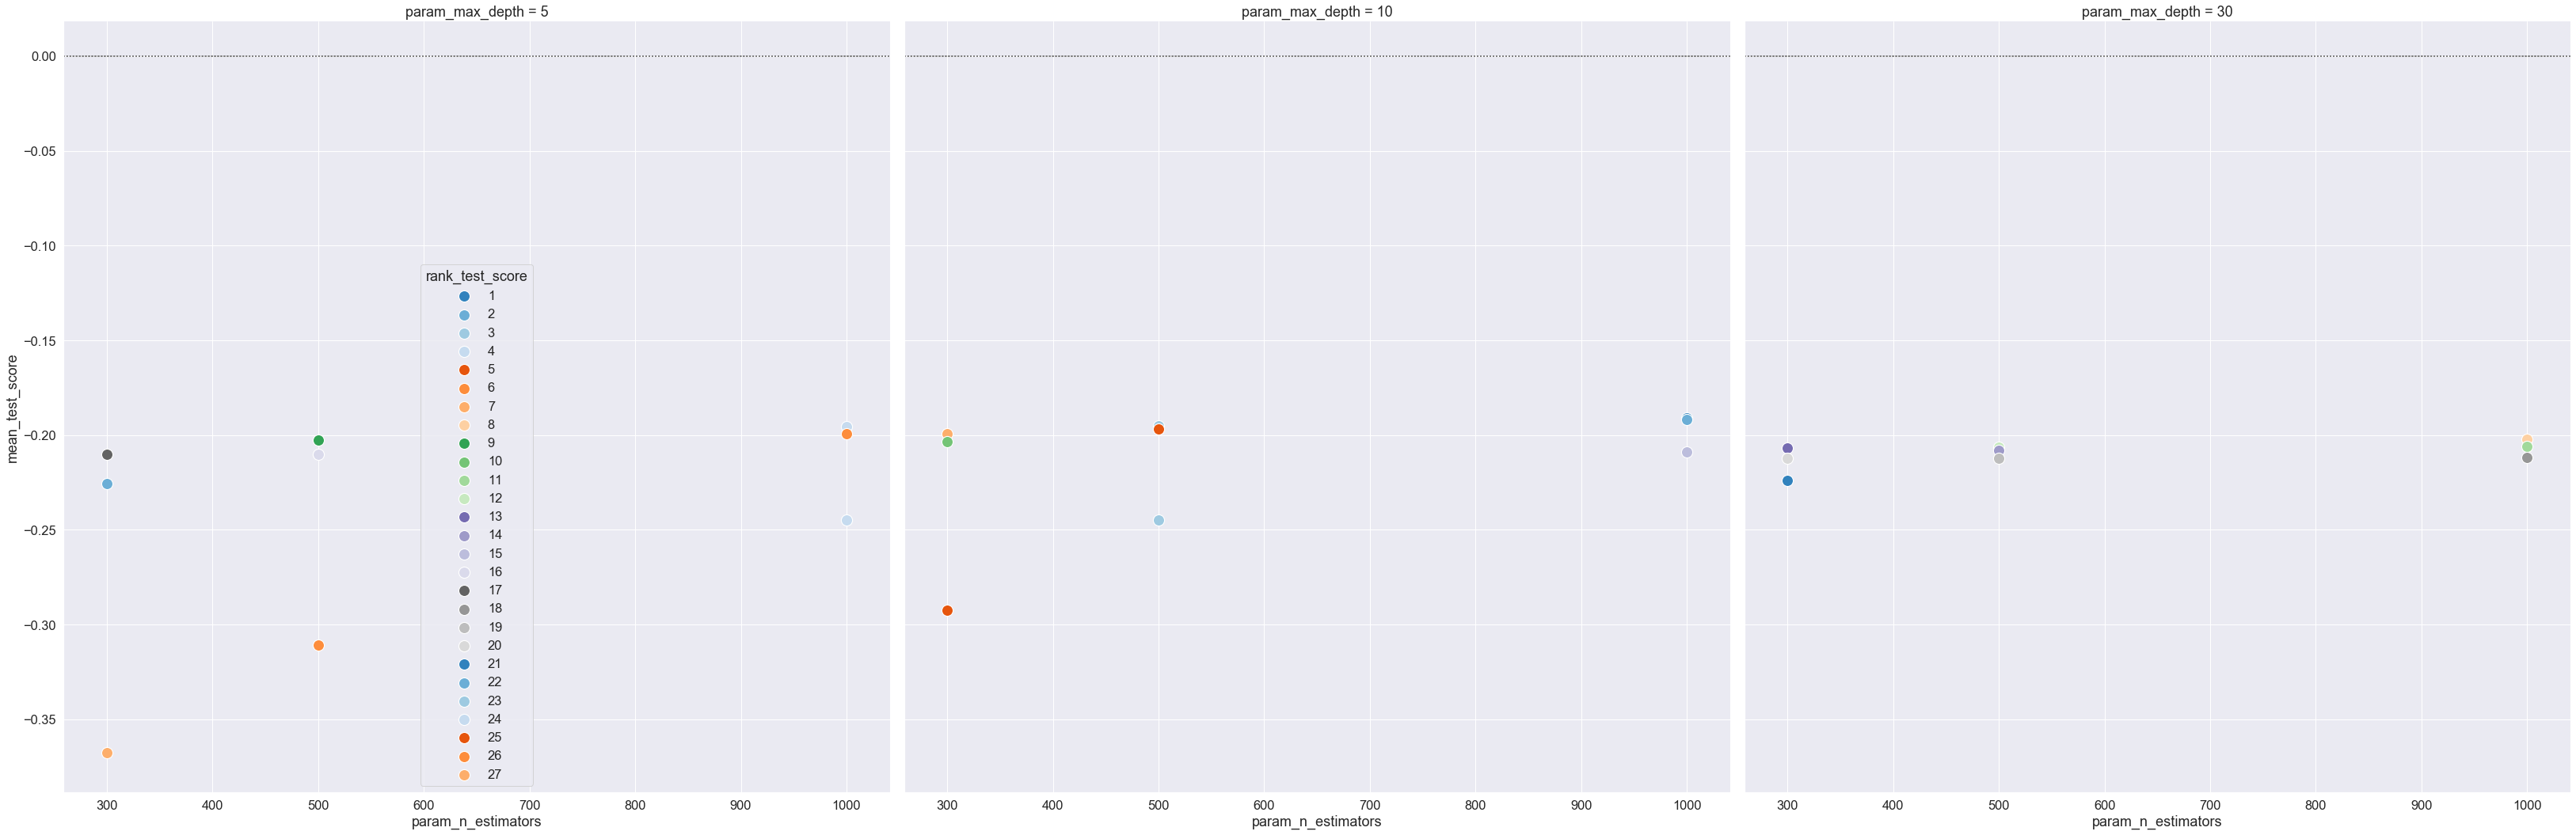

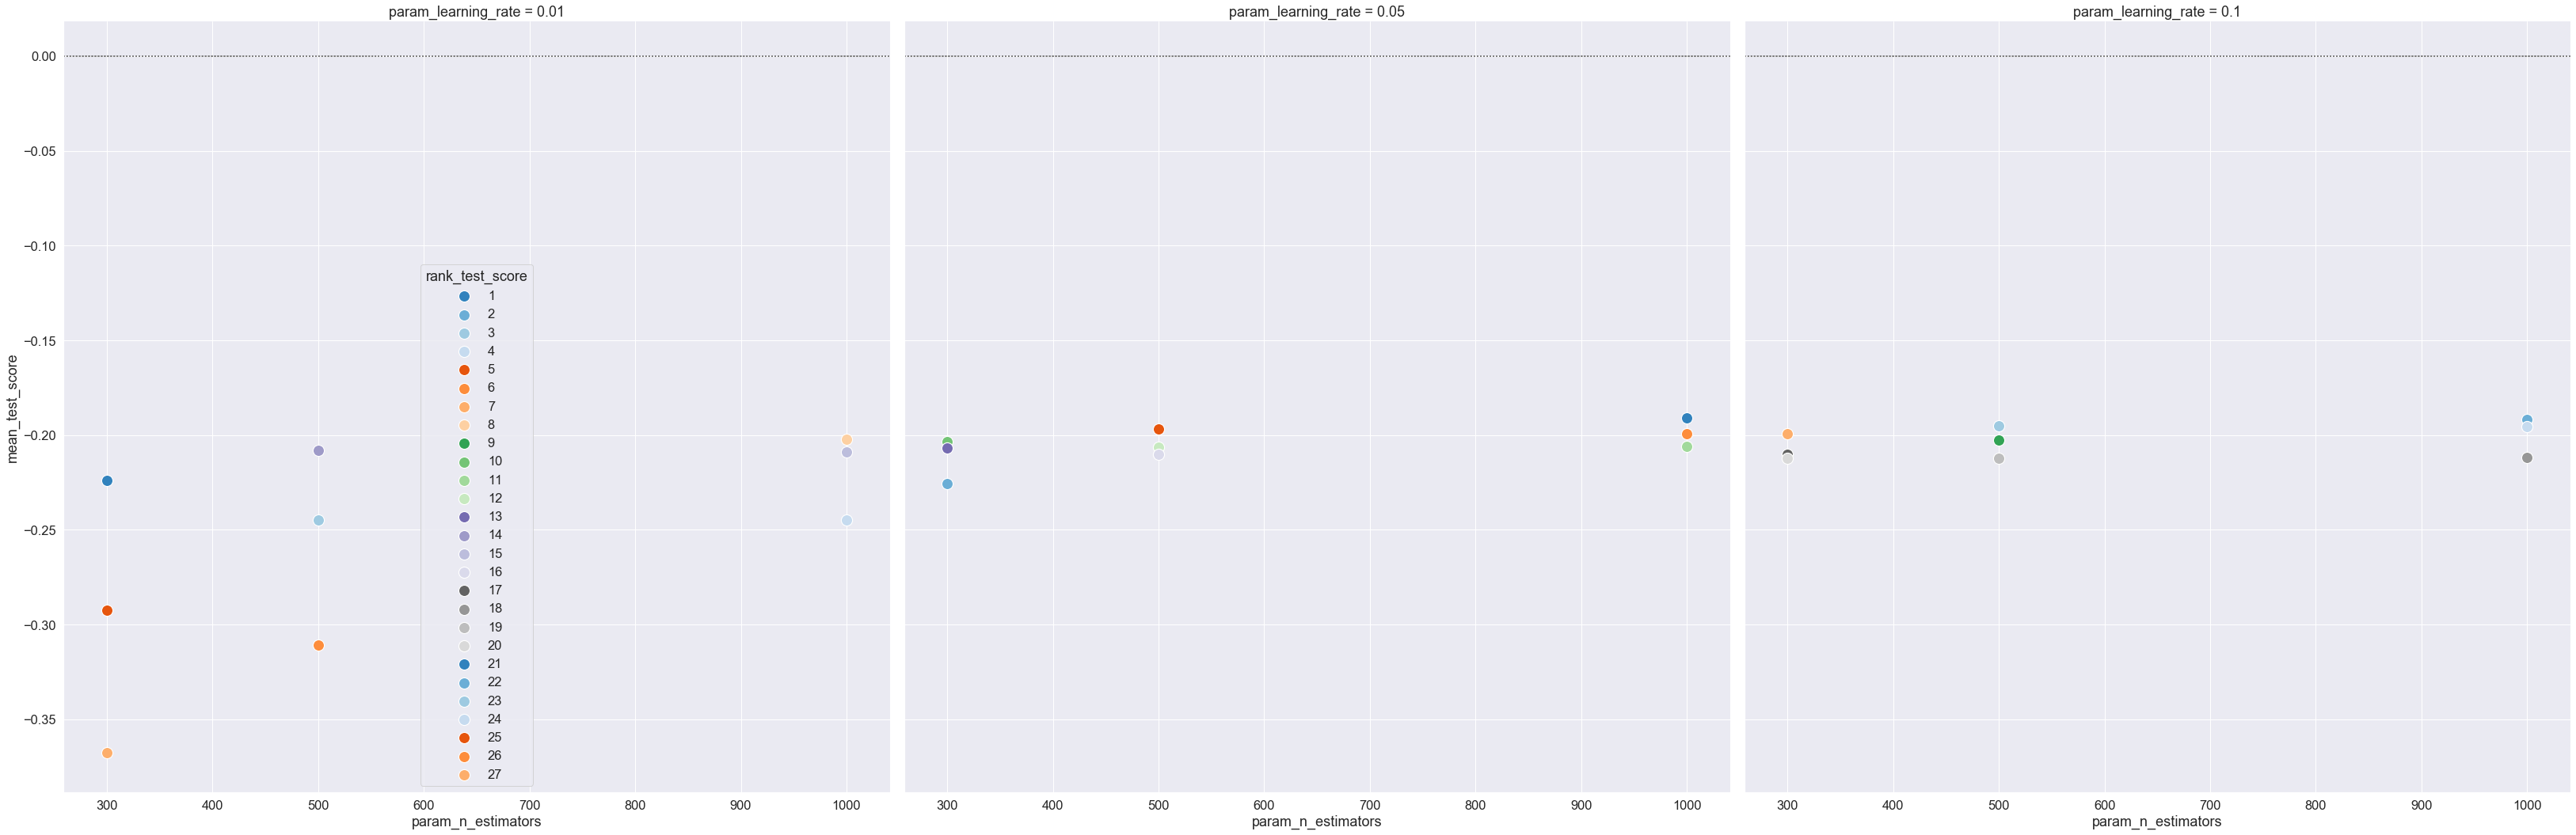

In [16]:
# Model 3: Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Set paramters for Grid Search CV
param_grid = {
    "n_estimators": [300, 500, 1000],
    "max_depth": [5, 10, 30],
    "learning_rate": [0.01, 0.05, 0.1],
}
model3 = GradientBoostingRegressor(random_state=0, max_features="sqrt")

Tuned_Model3 = model_pipeline(model3, param_grid, "neg_root_mean_squared_error")
plot_mean_scores(
    Tuned_Model3,
    ["param_max_depth", "param_learning_rate"],
    "param_n_estimators",
    "mean_test_score",
    "GradientBoosting",
)
plt.savefig('pictures/gradient_boost.png')